# Autodiff Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp)


This is a set of puzzles  about getting better at autodifferentiation
It's a follow up to the [Tensor Puzzles](https://github.com/srush/Tensor-Puzzles).



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/Autodiff-Puzzles/blob/main/autodiff_puzzlers.ipynb)



These puzzles are about grokking autodiff.
I give you a basic tensor-to-tensor function, and your goal is to give me the Jacobian.
If a function takes input a tensor of shape $I$ and outputs a tensor of shape $O$ the
Jacobian is a tensor of shape $(O, I)$  that contains each derivative $\frac{df(x)_o}{dx_i}$.
My recommendation is to work them out first with math and then think about how to write
this as a tensor function. It gets really hard.

## Rules and Tips

* Every answer is 1 line of 80-column code. Many of them can be done with 20 characters or so.
* Everything in these puzzles should be done basic operators, nothing fancy. You cannot call np.array, etc.
* Recall the basic multivariate calculus identities.

The visualization will show you $x$ and $f(x)$ as heat maps.
The spotlights show you what your current Jacobian looks like.

In [21]:
# @title Library Code (hide)

!pip install -qqq beartype git+https://github.com/chalk-diagrams/chalx jaxtyping
import jax
import jax.numpy as np
import random
from chalk import square, make_path
import jax.numpy as np
import numpy as onp
from matplotlib import colormaps
import matplotlib.pyplot as plt
import chalk
import jax
from jaxtyping import Shaped
from matplotlib.colors import TwoSlopeNorm
from beartype import beartype as typechecker
from jaxtyping import jaxtyped
import IPython

Array = np.ndarray


v = plt.get_cmap("RdBu")


def matrix(mat, n, d=0):
    s = square(1)
    shape = mat.shape
    if len(shape) >= 2 + d:
        I, J = shape[-2:]
    else:
        I = 1
        (J,) = shape[-1:]
    norm = TwoSlopeNorm(
        vmin=np.minimum(mat.min(), -1), vcenter=0, vmax=np.maximum(1, mat.max())
    )
    d = s.translate(np.arange(I)[:, None], np.arange(J)).fill_color(
        v(norm(mat))[..., :3]
    )
    return (
        s.translate(np.arange(I)[:, None], np.arange(J))
        .fill_color(v(norm(mat))[..., :3])
        .named(n)
        .concat()
        .concat()
    )


def connect(d, n, m, j):
    a = d.get_subdiagram(n).get_envelope().center
    b = d.get_subdiagram(m).get_envelope().center[:, :, None, None]
    p = (
        chalk.Path.from_points(
            [
                a + chalk.tx.V2(0, (0.5 / a.shape[0]) * np.arange(a.shape[0])[:, None]),
                b - chalk.tx.V2(0.5, 0.5),
                b + chalk.tx.V2(-0.5, 0.5),
                a + chalk.tx.V2(0, (0.5 / a.shape[0]) * np.arange(a.shape[0])[:, None]),
            ],
            True,
        )
        .stroke()
        .fill_color(np.where(j[..., None] > 0, v([1.0])[..., :3], v([0.0])[..., :3]))
        .line_width(0)
        .fill_opacity(0.5 * np.abs(j) / np.max(np.abs(j)))
    )
    return p.concat().concat().concat().concat()


def check(f, jac, in_shape, in_shape2=None):
    fp_x = jax.jacrev(f, 0)
    if in_shape2 is not None:
        fp_y = jax.jacrev(f, 1)
    f = jaxtyped(typechecker=typechecker)(f)
    jac = jaxtyped(typechecker=typechecker)(jac)
    x = np.array(onp.random.random(in_shape) - 0.5)
    # x = np.linspace(0, 10, 10)
    # x = (np.random.random((3, 3)) - 0.5) * 10
    fail = False

    def show(j_check_x, j_x):
        for i, ind in enumerate(zip(*onp.array(~np.isclose(j_check_x, j_x)).nonzero())):
            print(
                "Fail at:",
                list(map(int, ind)),
                "Yours: ",
                j_x[ind],
                "True:",
                j_check_x[ind],
            )
            if i > 10:
                break

    if in_shape2 is not None:
        y = np.array(onp.random.random(in_shape2) - 0.5)
        # y = np.linspace(0, 10, 10)
        f_xy = f(x, y)
        j_check_x = fp_x(x, y)
        j_check_y = fp_y(x, y)
        j_x, j_y = jac(x, y)
        if not np.isclose(j_check_x, j_x).all():
            fail = True
            print("x check failed")
            show(j_check_x, j_x)

        if not np.isclose(j_check_y, j_y).all():
            fail = True
            print("y check failed")
            show(j_check_y, j_y)
        j2_x = j_x[None, :, None, :] if f_xy.ndim == 1 else j_x
        j2_y = j_y[None, :, None, :] if f_xy.ndim == 1 else j_y
    else:
        f_xy = f(x)
        j_x = jac(x)
        j_check_x = fp_x(x)
        if not np.isclose(j_check_x, j_x).all():
            print("x check failed")
            fail = True
            show(j_check_x, j_x)

        j2_x = j_x
        if f_xy.ndim == 1 and x.ndim == 1:
            j2_x = j_x[None, :, None, :]
        if f_xy.ndim == 1 and x.ndim == 2:
            j2_x = j_x[None, :, :, :]

    def matrix_with_translation(data, name, d=0, translate_x=0, translate_y=0):
        return matrix(data, name, d).translate(translate_x, translate_y)

    xd = matrix_with_translation(x, "x")
    fd = matrix_with_translation(f_xy, "f", translate_x=10)
    d = xd + fd
    conn_x = connect(d, "x", "f", j2_x)

    if in_shape2 is not None:
        yd = matrix_with_translation(y, "y", translate_y=12)
        d += yd
        conn_y = connect(d, "y", "f", j2_y)

    eps = x.max() / 2 if in_shape2 is None else max(x.max(), y.max()) / 2
    offset = np.array([0, 1, 2, 3, 2, 1, 0])[:, None, None] * eps
    x_mat = matrix_with_translation(x + offset, "x", d=1)

    if in_shape2 is not None:
        y_mat = matrix_with_translation(y + offset, "y", d=1, translate_y=12)
        f_mat = matrix_with_translation(
            f_xy + (j_x * offset).sum(-1)[:, None] + (j_y * offset).sum(-1)[:, None],
            "f",
            d=1,
            translate_x=10,
        )
        d = (x_mat + y_mat + f_mat) + conn_x + conn_y
    else:
        if x.ndim == 1:
            f_mat = matrix_with_translation(
                f_xy + (j_x * offset).sum(-1)[:, None], "f", d=1, translate_x=10
            )
        else:
            offset = offset[..., None]
            if f_xy.ndim == 2:
                offset = offset[..., None]
            f_mat = matrix_with_translation(
                f_xy + (j_x * offset).sum(-1).sum(-1),
                "f",
                d=1,
                translate_x=10,
            )
        d = (x_mat + f_mat) + conn_x

    d = chalk.rectangle(10, 10).fill_opacity(0).line_width(0) + d
    d.animate_svg("/tmp/out.svg", 512)
    IPython.display.display(IPython.display.SVG("/tmp/out.svg"))

    if not fail:
        show_dog()
    return  # .animate_svg("out.svg", 512)

def show_dog():
    print("Passed Tests!")
    pups = [
    "2m78jPG",
    "pn1e9TO",
    "MQCIwzT",
    "udLK6FS",
    "ZNem5o3",
    "DS2IZ6K",
    "aydRUz8",
    "MVUdQYK",
    "kLvno0p",
    "wScLiVz",
    "Z0TII8i",
    "F1SChho",
    "9hRi2jN",
    "lvzRF3W",
    "fqHxOGI",
    "1xeUYme",
    "6tVqKyM",
    "CCxZ6Wr",
    "lMW0OPQ",
    "wHVpHVG",
    "Wj2PGRl",
    "HlaTE8H",
    "k5jALH0",
    "3V37Hqr",
    "Eq2uMTA",
    "Vy9JShx",
    "g9I2ZmK",
    "Nu4RH7f",
    "sWp0Dqd",
    "bRKfspn",
    "qawCMl5",
    "2F6j2B4",
    "fiJxCVA",
    "pCAIlxD",
    "zJx2skh",
    "2Gdl1u7",
    "aJJAY4c",
    "ros6RLC",
    "DKLBJh7",
    "eyxH0Wc",
    "rJEkEw4"]
    IPython.display.display(IPython.display.HTML("""
    <video alt="test" controls autoplay=1>
        <source src="https://openpuppies.com/mp4/%s.mp4"  type="video/mp4">
    </video>
    """%(random.sample(pups, 1)[0])))

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Problem 1: Id

Warmup: $f(x_0) = [x_0]$

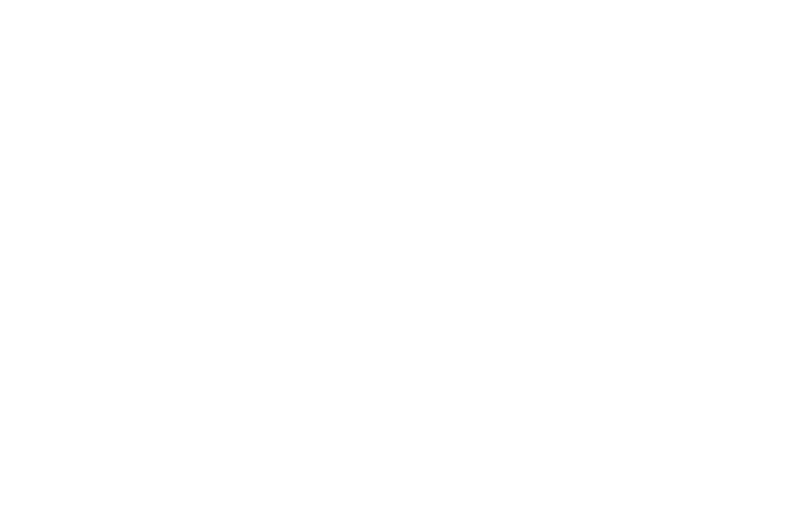

Passed Tests!


In [22]:

Is = np.arange(1)


def f(x: Shaped[Array, "1"]) -> Shaped[Array, "1"]:
    return 2 * x


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "1 1"]:
    return 2 + Is[None, :]  # fill in


check(f, jac, in_shape=Is.shape)

### Problem 2: Cosine

Warmup: $f(x_0) = [\cos(x_0)]$

x check failed
Fail at: [0, 0] Yours:  0.0 True: -0.02377815


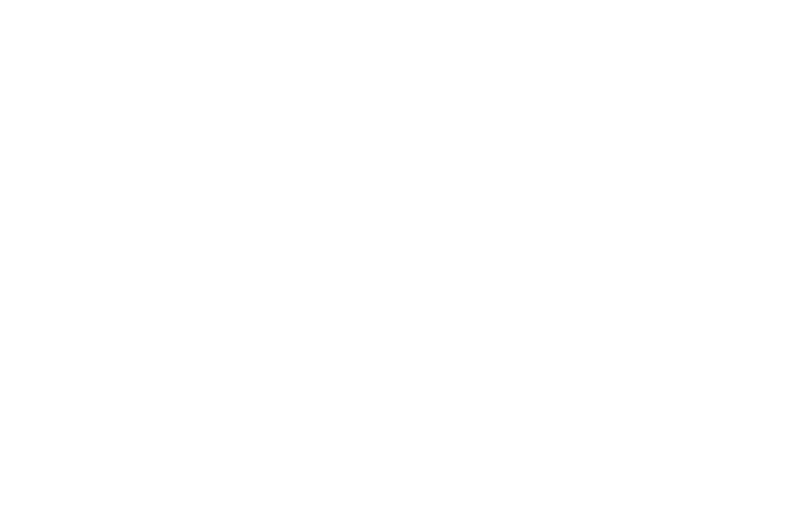

In [13]:
def f(x: Shaped[Array, "1"]) -> Shaped[Array, "1"]:
    return np.cos(x)


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "1 1"]:
    return 0. * Is[None, :]  # fill in


check(f, jac, in_shape=1)

### Problem 3: Mean

$f(x_0, x_1, \ldots, x_{I-1}) = [(x_0 + x_1 + \ldots + x_{I-1}) / I]$

x check failed
Fail at: [0, 0] Yours:  0.0 True: 0.1
Fail at: [0, 2] Yours:  0.2 True: 0.1
Fail at: [0, 3] Yours:  0.3 True: 0.1
Fail at: [0, 4] Yours:  0.4 True: 0.1
Fail at: [0, 5] Yours:  0.5 True: 0.1
Fail at: [0, 6] Yours:  0.6 True: 0.1
Fail at: [0, 7] Yours:  0.7 True: 0.1
Fail at: [0, 8] Yours:  0.8 True: 0.1
Fail at: [0, 9] Yours:  0.9 True: 0.1


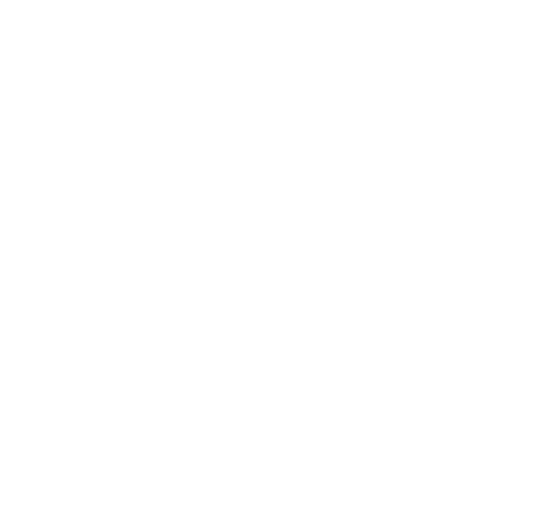

In [9]:
I = 10
Is = np.arange(I)


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "1"]:
    return np.mean(x, axis=0, keepdims=True)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "1 I"]:
    return 0 * Is[None, :]  # fill in


check(f, jac, in_shape=Is.shape)

### Problem 4: Product

$f(x_0, x_1, \ldots, x_{I-1}) = x_0 \times x_1 \times \ldots \times x_{I-1}$

x check failed
Fail at: [0, 0] Yours:  0 True: 3.059313e-06
Fail at: [0, 1] Yours:  0 True: -2.8897205e-06
Fail at: [0, 2] Yours:  0 True: -2.2334452e-05
Fail at: [0, 3] Yours:  0 True: 7.411885e-06
Fail at: [0, 4] Yours:  0 True: 2.2037325e-06
Fail at: [0, 5] Yours:  0 True: 2.4187318e-06
Fail at: [0, 6] Yours:  0 True: 3.5619719e-06
Fail at: [0, 7] Yours:  0 True: 2.5304125e-06
Fail at: [0, 8] Yours:  0 True: 5.4315997e-06
Fail at: [0, 9] Yours:  0 True: 3.1225718e-06
off (1, 1, 1, 10, 3, 3, 1)


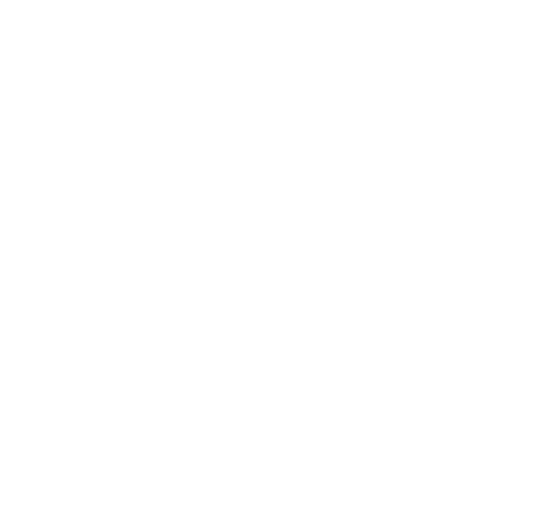

In [ ]:
def f(x: Shaped[Array, "I"]) -> Shaped[Array, "1"]:
    return np.prod(x, keepdims=True)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "1 I"]:
    return 0 * Is[None, :]  # fill in


check(f, jac, in_shape=Is.shape)

### Problem 5: Repeat

$f(x_0) = [x_0, x_0,  x_0, \ldots  x_0]$

Hint: The function `dx` should return a scalar. It is the
derivative of $f(x_0)_o$, i.e. the o'th output.


x check failed
Fail at: [0, 0] Yours:  0 True: 1.0
Fail at: [1, 0] Yours:  0 True: 1.0
Fail at: [2, 0] Yours:  0 True: 1.0
Fail at: [3, 0] Yours:  0 True: 1.0
Fail at: [4, 0] Yours:  0 True: 1.0
Fail at: [5, 0] Yours:  0 True: 1.0
Fail at: [6, 0] Yours:  0 True: 1.0
Fail at: [7, 0] Yours:  0 True: 1.0
Fail at: [8, 0] Yours:  0 True: 1.0
Fail at: [9, 0] Yours:  0 True: 1.0
off (1, 10, 1, 1, 3, 3, 1)


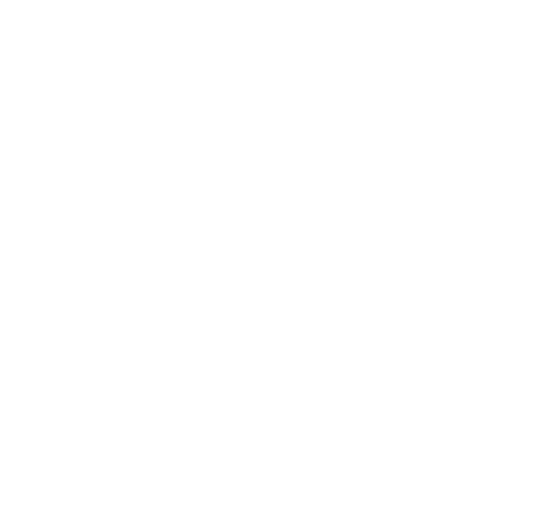

In [ ]:
Is = np.arange(1)
O = 10
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "1"]) -> Shaped[Array, "O"]:
    return (x + (Os * 0 + 1))[:, 0]


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "O 1"]:
    return 0 * Os  # fill in


check(f, jac, in_shape=Is.shape)

### Problem 6: Repeat and Scale

$$f(x_0) = [x_0 \times 0/I, x_0 \times 1/I,  x_0 \times 2/I,  \ldots,  x_{0} \times (I-1)/I]$$

x check failed
Fail at: [1, 0] Yours:  0 True: 0.1
Fail at: [2, 0] Yours:  0 True: 0.2
Fail at: [3, 0] Yours:  0 True: 0.3
Fail at: [4, 0] Yours:  0 True: 0.4
Fail at: [5, 0] Yours:  0 True: 0.5
Fail at: [6, 0] Yours:  0 True: 0.6
Fail at: [7, 0] Yours:  0 True: 0.7
Fail at: [8, 0] Yours:  0 True: 0.8
Fail at: [9, 0] Yours:  0 True: 0.9
off (1, 10, 1, 1, 3, 3, 1)


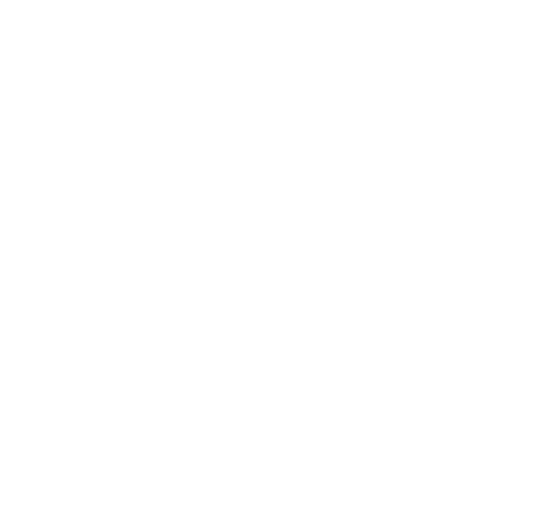

In [ ]:
Is = np.arange(1)
O = 10
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "1"]) -> Shaped[Array, "O"]:
    return x * (Os / O)[:, 0]


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "O 1"]:
    return 0 * Os  # fill in


check(f, jac, in_shape=Is.shape)

## Problem 7: Negation

$$f(x_0, x_1, \ldots) = [-x_0, -x_1, \ldots, -x_{I-1}]$$

x check failed
Fail at: [0, 0] Yours:  0 True: -1.0
Fail at: [1, 1] Yours:  0 True: -1.0
Fail at: [2, 2] Yours:  0 True: -1.0
Fail at: [3, 3] Yours:  0 True: -1.0
Fail at: [4, 4] Yours:  0 True: -1.0
Fail at: [5, 5] Yours:  0 True: -1.0
Fail at: [6, 6] Yours:  0 True: -1.0
Fail at: [7, 7] Yours:  0 True: -1.0
Fail at: [8, 8] Yours:  0 True: -1.0
Fail at: [9, 9] Yours:  0 True: -1.0


off (1, 10, 1, 10, 3, 3, 1)


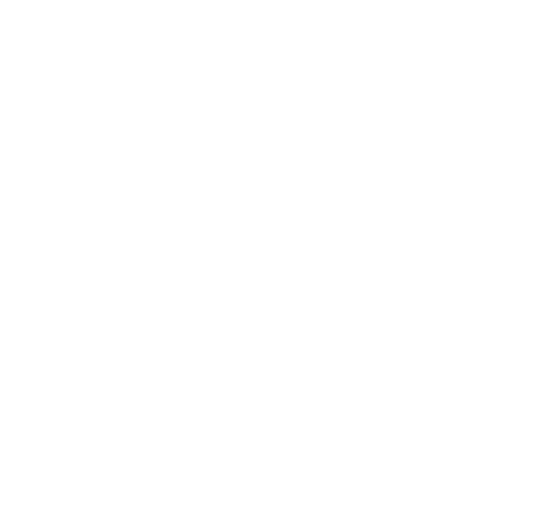

In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return -x


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape)

## Problem 8: ReLU

$$f(x_0, x_1, \ldots) = [\text{relu}(x_0), \text{relu}(x_1), \ldots]$$

Recall

$$
\text{relu}(x) = \begin{cases}
0 & x < 0 \\
x & x >= 0
\end{cases}
$$

(Note: you can ignore the not of non-differentiability at 0.)

x check failed
Fail at: [0, 0] Yours:  0 True: 1.0
Fail at: [1, 1] Yours:  0 True: 1.0
Fail at: [3, 3] Yours:  0 True: 1.0
Fail at: [7, 7] Yours:  0 True: 1.0
off (1, 10, 1, 10, 3, 3, 1)


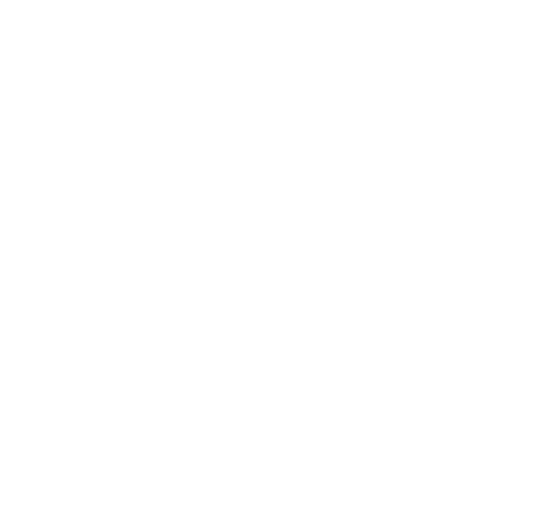

In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return x * (x > 0)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape)

## Problem 9: Index

$$f(x_0, x_1, \ldots, x_{24}) = [x_{10}, x_{11}, \ldots, x_{24}]$$



x check failed
Fail at: [0, 10] Yours:  0 True: 1.0
Fail at: [1, 11] Yours:  0 True: 1.0
Fail at: [2, 12] Yours:  0 True: 1.0
Fail at: [3, 13] Yours:  0 True: 1.0
Fail at: [4, 14] Yours:  0 True: 1.0
Fail at: [5, 15] Yours:  0 True: 1.0
Fail at: [6, 16] Yours:  0 True: 1.0
Fail at: [7, 17] Yours:  0 True: 1.0
Fail at: [8, 18] Yours:  0 True: 1.0
Fail at: [9, 19] Yours:  0 True: 1.0
Fail at: [10, 20] Yours:  0 True: 1.0
Fail at: [11, 21] Yours:  0 True: 1.0
off (1, 15, 1, 25, 3, 3, 1)


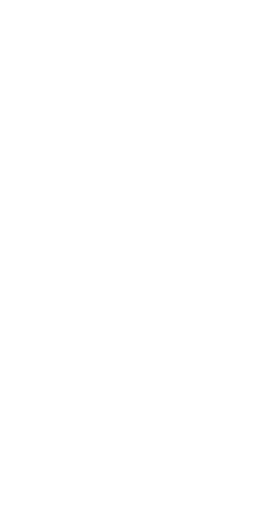

In [ ]:
I = 25
O = 15
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return x[10:]


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape)

## Problem 10: Cumsum

$$f(x_0, x_1, \ldots) = [\sum^0_{i=0} x_{i}, \sum^1_{i=0} x_{i}, \sum^2_{i=0} x_{i}, \ldots, ] / 20$$



x check failed
Fail at: [0, 0] Yours:  0 True: 0.05
Fail at: [1, 0] Yours:  0 True: 0.05
Fail at: [1, 1] Yours:  0 True: 0.05
Fail at: [2, 0] Yours:  0 True: 0.05
Fail at: [2, 1] Yours:  0 True: 0.05
Fail at: [2, 2] Yours:  0 True: 0.05
Fail at: [3, 0] Yours:  0 True: 0.05
Fail at: [3, 1] Yours:  0 True: 0.05
Fail at: [3, 2] Yours:  0 True: 0.05
Fail at: [3, 3] Yours:  0 True: 0.05
Fail at: [4, 0] Yours:  0 True: 0.05
Fail at: [4, 1] Yours:  0 True: 0.05
off (1, 10, 1, 10, 3, 3, 1)


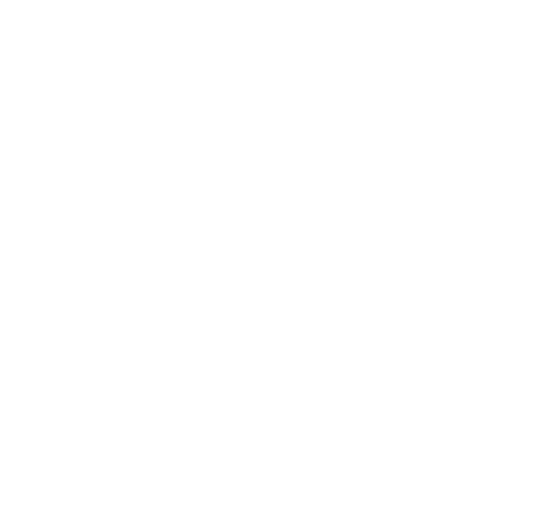

In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return np.cumsum(x) / 20


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape)

## Problem 11: Running Mean


$$f(x_0, x_1, \ldots)_o = \frac{\displaystyle \sum^o_{i=o-W} x_i}{W}$$

x check failed
Fail at: [0, 0] Yours:  0 True: 0.33333334
Fail at: [0, 1] Yours:  0 True: 0.33333334
Fail at: [0, 2] Yours:  0 True: 0.33333334
Fail at: [1, 1] Yours:  0 True: 0.33333334
Fail at: [1, 2] Yours:  0 True: 0.33333334
Fail at: [1, 3] Yours:  0 True: 0.33333334
Fail at: [2, 2] Yours:  0 True: 0.33333334
Fail at: [2, 3] Yours:  0 True: 0.33333334
Fail at: [2, 4] Yours:  0 True: 0.33333334
Fail at: [3, 3] Yours:  0 True: 0.33333334
Fail at: [3, 4] Yours:  0 True: 0.33333334
Fail at: [3, 5] Yours:  0 True: 0.33333334
off (1, 8, 1, 10, 3, 3, 1)


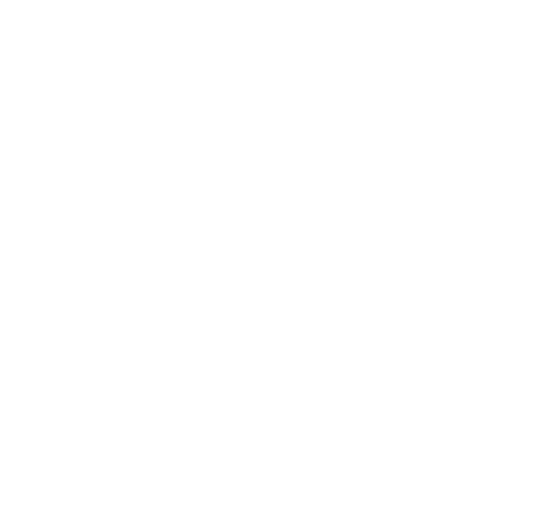

In [ ]:
I = 10
O = 8
Is = np.arange(I)
Os = np.arange(O)[:, None]
W = 3


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return np.convolve(x, np.ones(W) / W, mode="valid")


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape)

## Problem 12: Sort


$$f(x_0, x_1, \ldots) = \text{x's in sorted order}$$

You can use function like np.sort of this one.
(This one is a bit counterintuitive! Note that we are not asking you to differentiate the sorting function it self.)

x check failed
Fail at: [0, 3] Yours:  0 True: 1.0
Fail at: [1, 6] Yours:  0 True: 1.0
Fail at: [2, 4] Yours:  0 True: 1.0
Fail at: [3, 9] Yours:  0 True: 1.0
Fail at: [4, 5] Yours:  0 True: 1.0
Fail at: [5, 1] Yours:  0 True: 1.0
Fail at: [6, 0] Yours:  0 True: 1.0
Fail at: [7, 8] Yours:  0 True: 1.0
Fail at: [8, 7] Yours:  0 True: 1.0
Fail at: [9, 2] Yours:  0 True: 1.0
off (1, 10, 1, 10, 3, 3, 1)


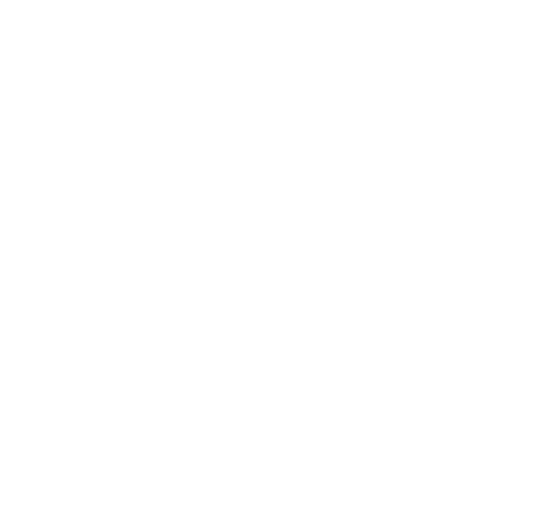

In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return np.sort(x)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape)

Next we move on to functions of two arguments. For these you will produce two derivatives: $$\frac{df(x, y)_o}{x_i}, \frac{df(x, y)_o}{y_j}$$. Everything else is the same.

## Problem 13: Elementwise mean

$$f(x, y)_o = (x_o + y_o) /2 $$

x check failed
Fail at: [0, 0] Yours:  0 True: 0.5
Fail at: [1, 1] Yours:  0 True: 0.5
Fail at: [2, 2] Yours:  0 True: 0.5
Fail at: [3, 3] Yours:  0 True: 0.5
Fail at: [4, 4] Yours:  0 True: 0.5
Fail at: [5, 5] Yours:  0 True: 0.5
Fail at: [6, 6] Yours:  0 True: 0.5
Fail at: [7, 7] Yours:  0 True: 0.5
Fail at: [8, 8] Yours:  0 True: 0.5
Fail at: [9, 9] Yours:  0 True: 0.5
y check failed
Fail at: [0, 0] Yours:  0 True: 0.5
Fail at: [1, 1] Yours:  0 True: 0.5
Fail at: [2, 2] Yours:  0 True: 0.5
Fail at: [3, 3] Yours:  0 True: 0.5
Fail at: [4, 4] Yours:  0 True: 0.5
Fail at: [5, 5] Yours:  0 True: 0.5
Fail at: [6, 6] Yours:  0 True: 0.5
Fail at: [7, 7] Yours:  0 True: 0.5
Fail at: [8, 8] Yours:  0 True: 0.5
Fail at: [9, 9] Yours:  0 True: 0.5
off (1, 10, 1, 10, 3, 3, 1)
off (1, 10, 1, 10, 3, 3, 1)


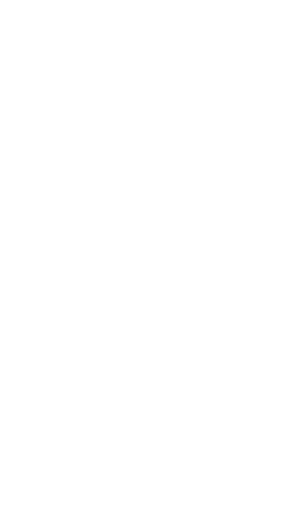

In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"], y: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return (x + y) / 2


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "I"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O I"]]:
    return 0 * (Os + Is), 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape, in_shape2=Is.shape)

## Problem 14: Elementwise mul

$$f(x, y)_o = x_o * y_o $$

x check failed
Fail at: [0, 0] Yours:  0 True: 0.0026589856
Fail at: [1, 1] Yours:  0 True: 0.008376902
Fail at: [2, 2] Yours:  0 True: -0.32991585
Fail at: [3, 3] Yours:  0 True: -0.25807047
Fail at: [4, 4] Yours:  0 True: -0.16827407
Fail at: [5, 5] Yours:  0 True: 0.34116557
Fail at: [6, 6] Yours:  0 True: -0.4451259
Fail at: [7, 7] Yours:  0 True: -0.39673752
Fail at: [8, 8] Yours:  0 True: 0.41499367
Fail at: [9, 9] Yours:  0 True: -0.33532274
y check failed
Fail at: [0, 0] Yours:  0 True: -0.064837635
Fail at: [1, 1] Yours:  0 True: -0.43554816
Fail at: [2, 2] Yours:  0 True: 0.0417673
Fail at: [3, 3] Yours:  0 True: -0.14772303
Fail at: [4, 4] Yours:  0 True: 0.47373062
Fail at: [5, 5] Yours:  0 True: -0.26549047
Fail at: [6, 6] Yours:  0 True: -0.009514991
Fail at: [7, 7] Yours:  0 True: 0.25594807
Fail at: [8, 8] Yours:  0 True: 0.28739682
Fail at: [9, 9] Yours:  0 True: -0.2843546
off (1, 10, 1, 10, 3, 3, 1)
off (1, 10, 1, 10, 3, 3, 1)


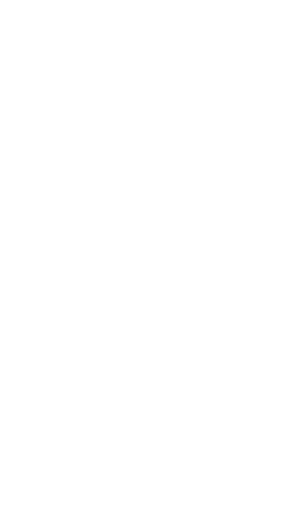

In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"], y: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return x * y


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "I"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O I"]]:
    return 0 * (Os + Is), 0 * (Os + Is)  # fill in


check(f, jac, in_shape=Is.shape, in_shape2=Is.shape)

## Problem 15: 1D Convolution

This is the standard 1D convolution used in deep learning. There is no wrap-around.

$$f(x, y)_o = \sum_{j=1}^K x_{o+j} * y_{j} / K $$

Note: This is probably the hardest one. The answer is short but tricky.

x check failed
Fail at: [0, 0] Yours:  0 True: -0.016965052
Fail at: [0, 1] Yours:  0 True: -0.016772147
Fail at: [0, 2] Yours:  0 True: 0.00032617207
Fail at: [0, 3] Yours:  0 True: -0.020288302
Fail at: [0, 4] Yours:  0 True: -0.003952173
Fail at: [1, 1] Yours:  0 True: -0.016965052
Fail at: [1, 2] Yours:  0 True: -0.016772147
Fail at: [1, 3] Yours:  0 True: 0.00032617207
Fail at: [1, 4] Yours:  0 True: -0.020288302
Fail at: [1, 5] Yours:  0 True: -0.003952173
Fail at: [2, 2] Yours:  0 True: -0.016965052
Fail at: [2, 3] Yours:  0 True: -0.016772147
y check failed
Fail at: [0, 0] Yours:  0 True: 0.060914684
Fail at: [0, 1] Yours:  0 True: -0.050731696
Fail at: [0, 2] Yours:  0 True: 0.063439615
Fail at: [0, 3] Yours:  0 True: 0.0010399771
Fail at: [0, 4] Yours:  0 True: 0.04047838
Fail at: [1, 0] Yours:  0 True: -0.09192101
Fail at: [1, 1] Yours:  0 True: 0.060914684
Fail at: [1, 2] Yours:  0 True: -0.050731696
Fail at: [1, 3] Yours:  0 True: 0.063439615
Fail at: [1, 4] Yours:  0 True

off (1, 6, 1, 5, 3, 3, 1)


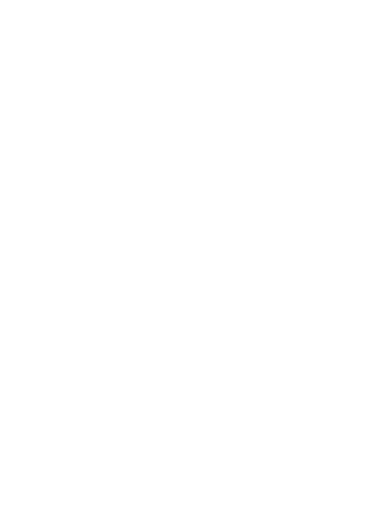

In [ ]:
I = 10
O = 6
W = 5
Is = np.arange(I)
Os = np.arange(O)[:, None]
Ws = np.arange(W)


def f(x: Shaped[Array, "I"], y: Shaped[Array, "W"]) -> Shaped[Array, "O"]:
    return np.convolve(x, y, mode="valid") / W


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "W"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O W"]]:
    return 0 * (Is + Os), 0 * (Os + Ws)  # fill in


check(f, jac, in_shape=Is.shape, in_shape2=Ws.shape)

## Problem 15: View

Compute the identity function for all $o,p$. $y$ is ignored.

$$f(X)_{o, p} = X_{o, p}$$

x check failed
Fail at: [0, 0, 0] Yours:  0 True: 1.0
Fail at: [0, 0, 1] Yours:  1 True: 0.0
Fail at: [0, 0, 2] Yours:  2 True: 0.0
Fail at: [0, 0, 3] Yours:  3 True: 0.0
Fail at: [0, 1, 0] Yours:  1 True: 0.0
Fail at: [0, 1, 1] Yours:  2 True: 0.0
Fail at: [0, 1, 2] Yours:  3 True: 0.0
Fail at: [0, 1, 3] Yours:  4 True: 0.0
Fail at: [0, 2, 0] Yours:  2 True: 0.0
Fail at: [0, 2, 1] Yours:  3 True: 0.0
Fail at: [0, 2, 2] Yours:  4 True: 0.0
Fail at: [0, 2, 3] Yours:  5 True: 0.0
off (1, 16, 4, 4, 3, 3, 1)


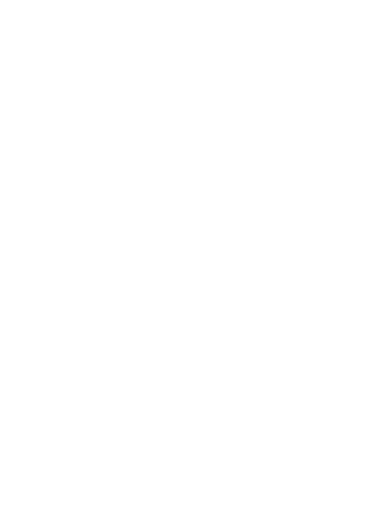

In [ ]:
I = 4
J = 4
O = 16
Is = np.arange(I)[:, None]
Js = np.arange(J)
Os = np.arange(O)[:, None, None]


def f(x: Shaped[Array, "I J"]) -> Shaped[Array, "O"]:
    return x.reshape((O,))


def jac(x: Shaped[Array, "I J"]) -> Shaped[Array, "O I J"]:
    return 0 * Os + Is + Js  # fill in


check(f, jac, in_shape=(I, J))

## Problem 16: Transpose

Transpose row and columns

$$f(X, y)_{o, p} = X_{p, o}$$


x check failed
Fail at: [0, 0, 0, 0] Yours:  0 True: 1.0
Fail at: [0, 1, 1, 0] Yours:  0 True: 1.0
Fail at: [0, 2, 2, 0] Yours:  0 True: 1.0
Fail at: [0, 3, 3, 0] Yours:  0 True: 1.0
Fail at: [1, 0, 0, 1] Yours:  0 True: 1.0
Fail at: [1, 1, 1, 1] Yours:  0 True: 1.0
Fail at: [1, 2, 2, 1] Yours:  0 True: 1.0
Fail at: [1, 3, 3, 1] Yours:  0 True: 1.0
Fail at: [2, 0, 0, 2] Yours:  0 True: 1.0
Fail at: [2, 1, 1, 2] Yours:  0 True: 1.0
Fail at: [2, 2, 2, 2] Yours:  0 True: 1.0
Fail at: [2, 3, 3, 2] Yours:  0 True: 1.0
off (4, 4, 4, 4, 3, 3, 1)


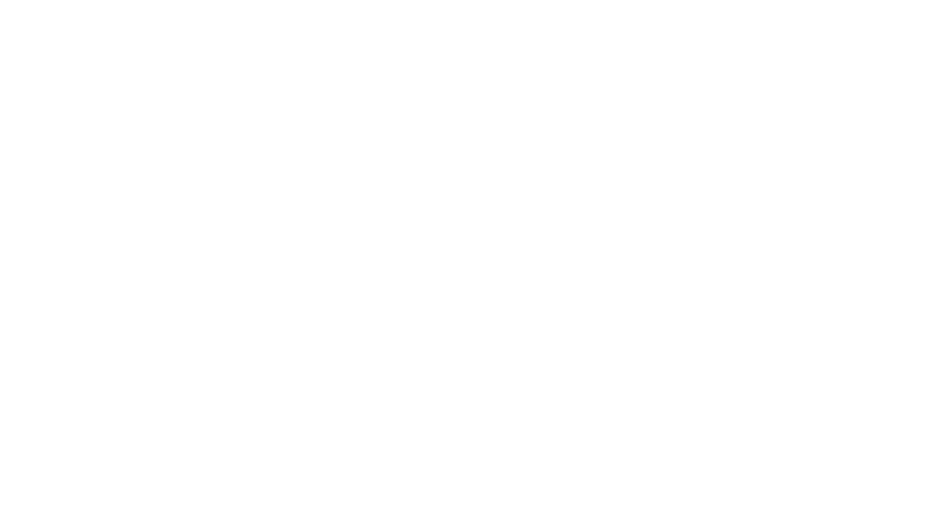

In [ ]:
I = 4
J = 4
O = 4
P = 4
Is = np.arange(I)[:, None]
Js = np.arange(J)
Os = np.arange(O)[:, None, None]
Ps = np.arange(P)[:, None, None, None]


def f(x: Shaped[Array, "I J"]) -> Shaped[Array, "O P"]:
    return x.T


def jac(x: Shaped[Array, "I J"]) -> Shaped[Array, "O P I J"]:
    return 0 * (Os + Is + Ps + Js)  # fill in


check(f, jac, in_shape=(I, J))

## Problem 18: Mean Reduce

Compute the mean over rows

$$f(X, y)_{o, p} = \sum_{i} X_{i, p} / R$$


x check failed
Fail at: [0, 0, 0] Yours:  0 True: 0.25
Fail at: [0, 1, 0] Yours:  0 True: 0.25
Fail at: [0, 2, 0] Yours:  0 True: 0.25
Fail at: [0, 3, 0] Yours:  0 True: 0.25
Fail at: [1, 0, 1] Yours:  0 True: 0.25
Fail at: [1, 1, 1] Yours:  0 True: 0.25
Fail at: [1, 2, 1] Yours:  0 True: 0.25
Fail at: [1, 3, 1] Yours:  0 True: 0.25
Fail at: [2, 0, 2] Yours:  0 True: 0.25
Fail at: [2, 1, 2] Yours:  0 True: 0.25
Fail at: [2, 2, 2] Yours:  0 True: 0.25
Fail at: [2, 3, 2] Yours:  0 True: 0.25
off (1, 4, 4, 4, 3, 3, 1)


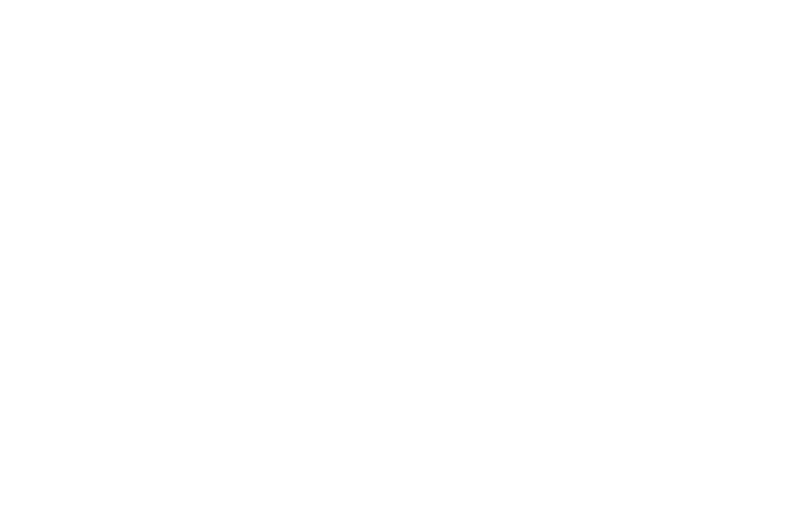

In [ ]:
I = 4
J = 4
O = 4
Is = np.arange(I)[:, None]
Js = np.arange(J)
Os = np.arange(O)[:, None, None]


def f(x: Shaped[Array, "I J"]) -> Shaped[Array, "O"]:
    return np.mean(x, axis=0)


def jac(x: Shaped[Array, "I J"]) -> Shaped[Array, "O I J"]:
    return 0 * (Is + Os + Js)  # fill in


check(f, jac, in_shape=(I, J))

## Problem 19: Matmul as vectors

Standard matrix multiplication

$$f(X, Y)_{o,p} = \sum_j X_{o, j} Y_{j,p}$$


x check failed
Fail at: [0, 0] Yours:  0 True: -0.20925549
Fail at: [0, 1] Yours:  0 True: 0.44882584
Fail at: [1, 0] Yours:  0 True: -0.079651125
Fail at: [1, 1] Yours:  0 True: -0.30817637
Fail at: [2, 2] Yours:  0 True: -0.20925549
Fail at: [2, 3] Yours:  0 True: 0.44882584
Fail at: [3, 2] Yours:  0 True: -0.079651125
Fail at: [3, 3] Yours:  0 True: -0.30817637
y check failed
Fail at: [0, 0] Yours:  0 True: 0.10303068
Fail at: [0, 2] Yours:  0 True: -0.2691448
Fail at: [1, 1] Yours:  0 True: 0.10303068
Fail at: [1, 3] Yours:  0 True: -0.2691448
Fail at: [2, 0] Yours:  0 True: 0.102117404
Fail at: [2, 2] Yours:  0 True: -0.37810177
Fail at: [3, 1] Yours:  0 True: 0.102117404
Fail at: [3, 3] Yours:  0 True: -0.37810177
off (1, 4, 1, 4, 3, 3, 1)
off (1, 4, 1, 4, 3, 3, 1)


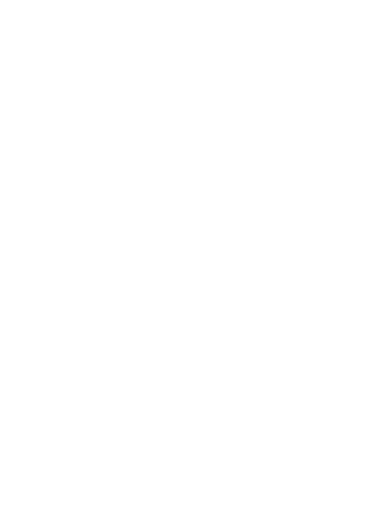

In [ ]:
I = 4
J = 4
O = 4
Is = np.arange(I)
Js = np.arange(J)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"], y: Shaped[Array, "J"]) -> Shaped[Array, "O "]:
    return (x.reshape(2, 2) @ y.reshape(2, 2)).reshape(O)


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "J"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O J"]]:
    return 0 * (Os == Is), 0 * (Os == Js)  # fill in


check(f, jac, in_shape=Is.shape, in_shape2=Js.shape)

## Problem 20: 2D Conv

Two Dimensional convolution

$$f(X, Y)_{o} = \sum_{dh}\sum_{dw} X_{o+dh*W+dw} Y_{dh,dw}$$



x check failed
Fail at: [0, 0] Yours:  0 True: 0.06773773
Fail at: [1, 0] Yours:  0 True: 0.0672402
Fail at: [1, 1] Yours:  0 True: 0.06773773
Fail at: [2, 1] Yours:  0 True: 0.0672402
Fail at: [2, 2] Yours:  0 True: 0.06773773
Fail at: [3, 2] Yours:  0 True: 0.0672402
Fail at: [3, 3] Yours:  0 True: 0.06773773
Fail at: [4, 0] Yours:  0 True: -0.07298884
Fail at: [4, 4] Yours:  0 True: 0.06773773
Fail at: [5, 0] Yours:  0 True: 0.09044005
Fail at: [5, 1] Yours:  0 True: -0.07298884
Fail at: [5, 4] Yours:  0 True: 0.0672402
y check failed
Fail at: [0, 0] Yours:  0 True: -0.10391527
Fail at: [1, 0] Yours:  0 True: -0.07405411
Fail at: [1, 1] Yours:  0 True: -0.10391527
Fail at: [2, 0] Yours:  0 True: 0.10947134
Fail at: [2, 1] Yours:  0 True: -0.07405411
Fail at: [3, 0] Yours:  0 True: -0.11266825
Fail at: [3, 1] Yours:  0 True: 0.10947134
Fail at: [4, 0] Yours:  0 True: 0.07168851
Fail at: [4, 2] Yours:  0 True: -0.10391527
Fail at: [5, 0] Yours:  0 True: 0.044710755
Fail at: [5, 1] You

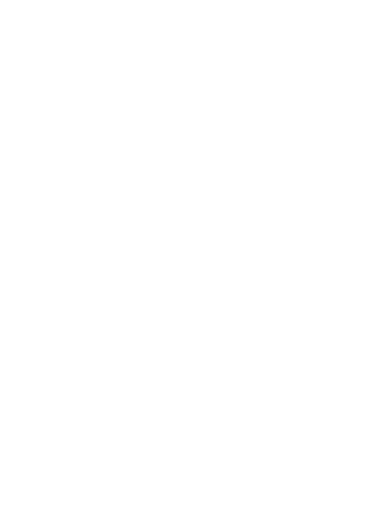

In [ ]:
from jax.scipy.signal import convolve2d

I = 16  # 4*4
J = 4  # 2*2
O = 16  # 4*4
Is = np.arange(I)
Js = np.arange(J)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"], y: Shaped[Array, "J"]) -> Shaped[Array, "O"]:
    X = x.reshape(4, 4)
    Y = y.reshape(2, 2)

    return convolve2d(X, Y, mode="same").reshape(-1) / (2 * 2)


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "J"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O J"]]:
    return 0 * (Os + Is), 0 * (Os + Js)  # fill in


check(f, jac, in_shape=Is.shape, in_shape2=Js.shape)